# Analytical Data Source

# P2.1 Select

Select: Selecting the analysis results for the technical and methodical provision.

Choosing analysis outcomes for technical and systematic planning.

In [195]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pandas as pd
import numpy as np
from torch.optim import lr_scheduler
import time
import os
from tempfile import TemporaryDirectory

df = pd.read_csv('../data/ds_salaries_cleaned.csv')

# P2.2 Request

Request: If the analysis results do not suit the intended technical and methodical provision, changes can be requested. 

The analysis results meet expectations, so skip this step.

# P2.3 Select

Select: This process aligns well with the requirement that data selected for technical and methodical provision should be appropriately prepared. If new data are introduced, they should be processed in the same manner to ensure consistency with the original model's data characteristics.

We calculate the 25th, 50th, and 75th percentiles of salaries in the 'salary_in_usd' column of the DataFrame df and define four salary levels based on these percentiles.

In [196]:
# calculate the percentiles
def convertData(data):
    
    percentiles = np.percentile(df['salary_in_usd'], [25, 75])  # 25th, 50th, 75th percentiles
    print(percentiles)
    # define the labels of saraly levels 
    labels = ['Level 1', 'Level 2', 'Level 3']

    # print the meaning of label 
    for i in range(len(labels)):
        if i == 0:
            print('Level 1: < {:.2f} USD'.format(percentiles[i]))
        elif i == len(labels) - 1:
            print('Level {}: > {:.2f} USD'.format(i+1, percentiles[i-1]))
        else:
            print('Level {}: {:.2f} ~ {:.2f} USD'.format(i+1, percentiles[i-1], percentiles[i]))


    #  -np.inf, np.inf be the lower and upper bounds of the bins
    # *percentiles: base on the percentiles to cut the bins and generate the salary levels for being the labels of training data
    df['salary_level'] = pd.cut(df['salary_in_usd'], bins=[-np.inf, *percentiles, np.inf], labels=labels)
    data = df.drop(['salary_in_usd'], axis=1) # we cannot put the label into the training data
    print("\nThe data of each salary level is balanced.")
    print(data['salary_level'].value_counts())
    return data



# P2.4 Request

Request: If the selected data do not suit the intended technical and methodical provision, changes can be requested. 

The selected data suit the intended technical and methodical provision,so skip this step. 

# P2.5 Check

Check: During the technical and methodical provision, the applicability must be checked by 
the target group for the analysis. 

We check by the target group for the analysis. It check the data is balanced or not and calculate each salary level's data

In [197]:
data = convertData(df)
data
# each number of salary level have approximately the same number of data which occupy 25% of the whole data

[ 95000. 175000.]
Level 1: < 95000.00 USD
Level 2: 95000.00 ~ 175000.00 USD
Level 3: > 175000.00 USD

The data of each salary level is balanced.
salary_level
Level 2    1867
Level 1     956
Level 3     932
Name: count, dtype: int64


,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary_level
0,2023,Senior-level/Expert,Full-Time,Data Scientist,ES,100,ES,L,Level 1
1,2023,Mid-level/Intermediate,Contract,ML Engineer,US,100,US,S,Level 1
2,2023,Mid-level/Intermediate,Contract,ML Engineer,US,100,US,S,Level 1
3,2023,Senior-level/Expert,Full-Time,Data Scientist,CA,100,CA,M,Level 2
4,2023,Senior-level/Expert,Full-Time,Data Scientist,CA,100,CA,M,Level 2
...,...,...,...,...,...,...,...,...,...
3750,2020,Senior-level/Expert,Full-Time,Data Scientist,US,100,US,L,Level 3
3751,2021,Mid-level/Intermediate,Full-Time,Data Scientist,US,100,US,L,Level 2
3752,2020,Entry-level/Junior,Full-Time,Data Scientist,US,100,US,S,Level 2
3753,2020,Entry-level/Junior,Contract,Data Analyst,US,100,US,L,Level 2


# P2.6 Apply

Apply: Identified opportunities for ensuring applicability must be considered during the technical and methodical provision.

We create the function to convert the data for training and testing, ensuring applicability by turning the data into tensors and normalizing it, while considering identified opportunities during the technical and methodical provision.

In [198]:
class SalaryDataset(Dataset):

    # Initialization function for loading and preprocessing data
    def __init__(self, data, train=True, transform=None):
        # The 'train' parameter indicates whether the data is for training or testing
        self.train = train

        # Create MinMaxScaler and OneHotEncoder for data preprocessing
        minmax_scaler = MinMaxScaler()
        onehot_enc = OneHotEncoder()

        # Split data into categorical features, numerical features, and labels
        categorical_features = data[data.select_dtypes(include=['object']).columns]
        numerical_features = data[data.select_dtypes(exclude=['object']).columns].drop('salary_level', axis=1)
        label_features = data[['salary_level']]

        # Normalize numerical features (MinMax normalization)
        numerical_features_arr = minmax_scaler.fit_transform(numerical_features)

        # Perform one-hot encoding on categorical features
        categorical_features_arr = onehot_enc.fit_transform(categorical_features).toarray()

        # After one-hot encoding categorical features, retrieve the encoded feature names
        label_features = onehot_enc.fit_transform(label_features).toarray()

        # Combine normalized numerical features and one-hot encoded categorical features into one dataset
        combined_features = pd.DataFrame(data=numerical_features_arr, columns=numerical_features.columns)
        combined_features = pd.concat([combined_features, pd.DataFrame(data=categorical_features_arr)], axis=1)
        combined_features = pd.concat([combined_features, pd.DataFrame(data=label_features)], axis=1).reset_index(drop=True)

        # Split the dataset into training and testing sets
        train_data, test_data = train_test_split(combined_features, test_size=0.2, random_state=42)

        # Choose the data to use based on the training or testing mode
        if train:
            self.data = train_data
        else:
            self.data = test_data

    # Returns the length of the dataset
    def __len__(self):
        return len(self.data)

    # Function for training the neural network, returns features and labels
    def __getitem__(self, idx):
        # Retrieve the data from the ith row in the self.data DataFrame
        sample = self.data.iloc[idx] 
        # Convert a data structure into a PyTorch tensor and specify the tensor's data type as float
        features = torch.FloatTensor(sample[:-4])
        label = torch.FloatTensor(sample[-4:])
        return features, label

    # Returns the entire dataset as a DataFrame
    def getData(self):
        return self.data


# P2.7 Check

Check: During the technical and methodical provision, technical requirements must be examined.

Create«

In [199]:
train_dataset = SalaryDataset(data, train=True) 
test_dataset = SalaryDataset(data, train=False)
print('train_dataset len:', len(train_dataset))
print('val_dataset len:', len(test_dataset))
print('total_dataset len:', len(train_dataset) + len(test_dataset))

train_dataset len: 3004
val_dataset len: 751
total_dataset len: 3755


In [200]:
test_dataset.getData().shape

(751, 177)

In [201]:
data.head()

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary_level
0,2023,Senior-level/Expert,Full-Time,Data Scientist,ES,100,ES,L,Level 1
1,2023,Mid-level/Intermediate,Contract,ML Engineer,US,100,US,S,Level 1
2,2023,Mid-level/Intermediate,Contract,ML Engineer,US,100,US,S,Level 1
3,2023,Senior-level/Expert,Full-Time,Data Scientist,CA,100,CA,M,Level 2
4,2023,Senior-level/Expert,Full-Time,Data Scientist,CA,100,CA,M,Level 2


# P2.8 Apply 

Apply: Any technical impossibilities for implementation identified must be considered during the technical and methodical provision.

It involves technical setup for handling data, which is a crucial part of the methodical provision in machine learning or data processing projects. Ensuring the correct handling and sizing of datasets is vital to the success of such projects, and any technical impossibilities or limitations identified in this area must be addressed.

In [202]:
# Create DataLoader for training and testing datasets 
dataloaders = {'train': train_dataset, 'test': test_dataset}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'test']}
dataset_sizes

{'train': 3004, 'test': 751}

The function for training and testing data is created.
This will train 25 epochs, and save the best model during training. 

In [203]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=1):
    since = time.time()
    with TemporaryDirectory() as tempdir:
        # Path to save the best model parameters
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                # Set model to training mode or evaluation mode
                if phase == 'train':
                    model.train()  # Training mode
                else: 
                    model.eval()   # Evaluation mode
                
                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs_vector, labels_vector in dataloaders[phase]:

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass: compute predicted outputs by passing inputs to the model
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs_vector)

                        # Predictions and actual results
                        pred = torch.argmax(outputs).item()
                        result = torch.argmax(labels_vector).item()
                        # Calculate loss
                        loss = criterion(outputs, labels_vector)

                        # Backward pass and optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics: accumulate loss and count correct predictions
                    running_loss += loss.item()
                    if pred == result:
                        running_corrects += 1

                # Learning rate scheduler step in training phase
                if phase == 'train':
                    scheduler.step()

                # Calculate loss and accuracy for each epoch
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                if phase == 'train':
                    train_acc.append(epoch_acc)
                else:
                    test_acc.append(epoch_acc)
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Time elapsed: {round((time.time() - since))} sec.')
                
                # Save the model if it has the best accuracy so far
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        # Print out total time for training and the best accuracy
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # Load the best model weights before proceeding to the next epoch
        model.load_state_dict(torch.load(best_model_params_path))
    return model


Create a neural network model

In [204]:
class SalaryPredictor(nn.Module):
    def __init__(self, input_size):
        super(SalaryPredictor, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        # self.layer3 = nn.Linear(32, 16)
        # self.layer4 = nn.Linear(16, 8)
        self.output_layer = nn.Linear(32, 4)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        # x = torch.relu(self.layer3(x))
        # x = torch.relu(self.layer4(x))
        x = self.output_layer(x)
        return x


In [205]:
# TODO: add the comment for try and errors
train_acc = [] 
test_acc = []

D_in, D_out = 173, 4
model = SalaryPredictor(D_in)
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.01)
loss_function = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# P2.9 Provide

Provide: The results of the technical and methodical provision form the basis for the professional provision of the prepared analysis results for the target user group. The effects can range from a support of existing processes to a project adjustment to a completely new development (now automated, if applicable) of processes.

Technical provision results underpin targeted user analysis with epoch data. And finally save the best prediction result of model, which is easy to deploy and use in the future. 

## Conclusion
### Original Parameters
- 2-layer linear networks: (64, 32), (32, 16); output layer (16, 4)
- Criterion: BCELoss()
- Optimizer: AdamW with a learning rate of 0.001
- Loss function: CrossEntropyLoss()

### Search for Optimal Parameters
- Changing lr from 0.01 to 0.001 resulted in improved performance: 0.259654 -> 0.327563
- Updating momentum from 0.01 to 0.9 led to better results: 0.327563 -> 0.488682
- Switching from SGD to AdamW as the optimizer slightly increased accuracy: 0.488682 -> 0.490013
- Trying a different criterion, changing from CrossEntropyLoss() to BCELoss(), did not yield improvement.

### Label Modification
25th, 50th, and 75th percentiles of salaries: (95000, 135000, 175000)
1. Changing from [25, 50, 75] to [50], with a cut-off at 135,000.00 (NTD 4 million): Accuracy 91%
2. Changing from [25, 50, 75] to [75], with a cut-off at 175,000.00 (NTD 5 million): Accuracy 89%
3. Changing from [25, 50, 75] to [25, 75] (95000, 175000), with cut-offs at 95,000.00 and 175,000.00: Accuracy 64%

### Exploring Alternative Approaches
- Even with cleaning, the results remained relatively consistent.
- Significant changes in occupation visibly affect the model's predictions. However, due to the low diversity in samples for work_year, remote_rate, and company_location, the predictive results are limited.

In [206]:
model = train_model(model, loss_function, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


train Loss: 0.9649 Acc: 0.5719 Time elapsed: 2 sec.
test Loss: 0.8782 Acc: 0.6165 Time elapsed: 2 sec.

Epoch 1/24
----------
train Loss: 0.8577 Acc: 0.6212 Time elapsed: 5 sec.
test Loss: 0.8654 Acc: 0.6072 Time elapsed: 5 sec.

Epoch 2/24
----------
train Loss: 0.8378 Acc: 0.6328 Time elapsed: 7 sec.
test Loss: 0.8609 Acc: 0.6192 Time elapsed: 7 sec.

Epoch 3/24
----------
train Loss: 0.8275 Acc: 0.6411 Time elapsed: 9 sec.
test Loss: 0.8643 Acc: 0.6218 Time elapsed: 9 sec.

Epoch 4/24
----------
train Loss: 0.8198 Acc: 0.6428 Time elapsed: 11 sec.
test Loss: 0.8704 Acc: 0.6312 Time elapsed: 11 sec.

Epoch 5/24
----------
train Loss: 0.8137 Acc: 0.6458 Time elapsed: 13 sec.
test Loss: 0.8605 Acc: 0.6352 Time elapsed: 14 sec.

Epoch 6/24
----------
train Loss: 0.8069 Acc: 0.6525 Time elapsed: 16 sec.
test Loss: 0.8731 Acc: 0.6272 Time elapsed: 16 sec.

Epoch 7/24
----------
train Loss: 0.7869 Acc: 0.6605 Time elapsed: 18 sec.
test Loss: 0.8687 Acc: 0.6352 Time elapsed: 18 sec.

Epoch 

Text(0, 0.5, 'Accuracy')

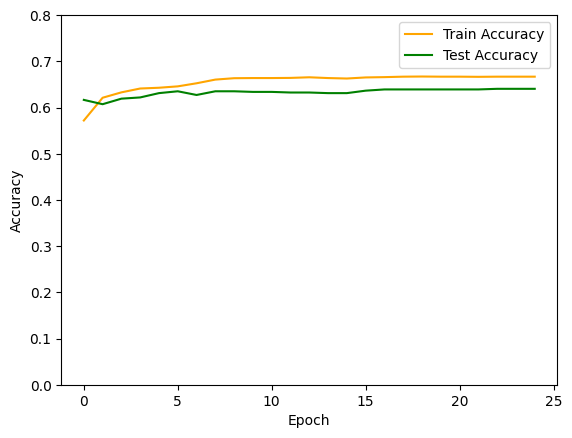

In [207]:
import matplotlib.pyplot as plt
plt.plot(train_acc, color='orange')
plt.plot(test_acc, color='green')
plt.ylim(0.0, 0.8)
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [208]:
# save the model to disk. (2L=50th; 4L=25,50,75th; 3L=25,50th)
torch.save(model.state_dict(), '../data/model/salary_pred_3L.pt')

### Predict the value with the model
1. Get all data from the source.
2. Add new data to the source.
3. Convert the data to datasource for model prediction.
4. Get the model and predict the value with the last data in the source. 

> 1. Get all data from the source

In [209]:
df = pd.read_csv('../data/ds_salaries_cleaned.csv')
data = convertData(df)

[ 95000. 175000.]
Level 1: < 95000.00 USD
Level 2: 95000.00 ~ 175000.00 USD
Level 3: > 175000.00 USD

The data of each salary level is balanced.
salary_level
Level 2    1867
Level 1     956
Level 3     932
Name: count, dtype: int64


> 2. Add new data to the source

In [210]:
hight_input = {
    'work_year': 2023,
    'experience_level': 'Senior-level/Expert',
    'employment_type': 'Full-Time',
    'job_title': 'Data Science Manager',
    'employee_residence': ['US'],
    'remote_ratio': [100],
    'company_location': ['US'],
    'company_size': ['L'],
    'salary_level': ['Level 1'] # we don't care about the label
}

low_intput = {
    'work_year': 2023,
    'experience_level': 'Entry-level/Junior',
    'employment_type': 'Full-Time',
    'job_title': 'Data Analyst',
    'employee_residence': ['US'],
    'remote_ratio': [100],
    'company_location': ['US'],
    'company_size': ['L'],
    'salary_level': ['Level 1'] # we don't care about the label
}

input = low_intput

data = pd.concat([data, pd.DataFrame(input)], ignore_index=True)
data.tail()

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary_level
3751,2021,Mid-level/Intermediate,Full-Time,Data Scientist,US,100,US,L,Level 2
3752,2020,Entry-level/Junior,Full-Time,Data Scientist,US,100,US,S,Level 2
3753,2020,Entry-level/Junior,Contract,Data Analyst,US,100,US,L,Level 2
3754,2021,Senior-level/Expert,Full-Time,Data Science Manager,IN,50,IN,L,Level 1
3755,2023,Entry-level/Junior,Full-Time,Data Analyst,US,100,US,L,Level 1


> 3. Convert the data to datasource for model prediction.

In [211]:
data.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
salary_level          object
dtype: object

In [212]:
class DatasetConverter(Dataset):

    # Initialization function for loading and preprocessing data
    def __init__(self, data, transform=None):
        # Create MinMaxScaler and OneHotEncoder for data preprocessing
        minmax_scaler = MinMaxScaler()
        onehot_enc = OneHotEncoder()

        # Split data into categorical features, numerical features, and labels
        categorical_features = data[data.select_dtypes(include=['object']).columns].drop('salary_level', axis=1)
        categorical_columns = data.select_dtypes(include=['object']).columns
        print(f'categorical_features=${categorical_columns}')

        numerical_features = data[data.select_dtypes(exclude=['object']).columns]
        numerical_columns = data.select_dtypes(exclude=['object']).columns
        print(f'numerical_features=${numerical_columns}')
        
        label_features = data[['salary_level']]

        # Normalize numerical features (MinMax normalization)
        numerical_features_arr = minmax_scaler.fit_transform(numerical_features)

        # Perform one-hot encoding on categorical features
        categorical_features_arr = onehot_enc.fit_transform(categorical_features).toarray()

        # After one-hot encoding categorical features, retrieve the encoded feature names
        label_features = onehot_enc.fit_transform(label_features).toarray()

        # Combine normalized numerical features and one-hot encoded categorical features into one dataset
        combined_features = pd.DataFrame(data=numerical_features_arr, columns=numerical_features.columns)
        combined_features = pd.concat([combined_features, pd.DataFrame(data=categorical_features_arr)], axis=1)
        combined_features = pd.concat([combined_features, pd.DataFrame(data=label_features)], axis=1).reset_index(drop=True)

        self.data = combined_features

    # Returns the length of the dataset
    def __len__(self):
        return len(self.data)

    # Function for retrieving features and labels for training the neural network
    def __getitem__(self, idx):
        # Retrieve the data from the ith row in the self.data DataFrame
        sample = self.data.iloc[idx] 
        # Convert a data structure into a PyTorch tensor and specify the tensor's data type as float
        features = torch.FloatTensor(sample[:-4])
        label = torch.FloatTensor(sample[-4:])
        return features, label

    # Returns the entire dataset as a DataFrame
    def getData(self):
        return self.data


In [213]:
# -1 is for get the last row of the data
tensor_input = DatasetConverter(data).__getitem__(-1)[0]
tensor_label = DatasetConverter(data).__getitem__(-1)[1]
print(f'tensor_input = ${tensor_input}, \ntensor_label = ${tensor_label}')

categorical_features=$Index(['experience_level', 'employment_type', 'job_title',
       'employee_residence', 'company_location', 'company_size',
       'salary_level'],
      dtype='object')
numerical_features=$Index(['work_year', 'remote_ratio'], dtype='object')
categorical_features=$Index(['experience_level', 'employment_type', 'job_title',
       'employee_residence', 'company_location', 'company_size',
       'salary_level'],
      dtype='object')
numerical_features=$Index(['work_year', 'remote_ratio'], dtype='object')
tensor_input = $tensor([1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.

# P2.10 Request

Request: If the professional provision does not lead to the desired results, changes to the technical and methodical provision can be requested.

In this step, we give the mock data to the model and predict the value. If the result is not as expected, we can request changes to the technical and methodical provision.

In [214]:
# load the model from disk
D_in, D_out = 174, 4
pred_model = SalaryPredictor(D_in)
pred_model.load_state_dict(torch.load('../data/model/salary_pred.pt'))

# predict the salary level of the new data
with torch.no_grad():
    # get the last row of the data
    tensor_data = DatasetConverter(data).__getitem__(-1)
    input = tensor_data[0]
    output = pred_model(input)
    print(f'output = ${output}')
    pred = torch.argmax(output).item()
    print('The predicted salary level is:', pred)

FileNotFoundError: [Errno 2] No such file or directory: '../data/model/salary_pred.pt'